In [4]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from keras.models import Sequential 
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.layers import Lambda, Conv2D, Dropout, Dense, Flatten
from keras.regularizers import l2

from utils import INPUT_SHAPE, batch_generator

(array([   7.,   15.,   50.,  121.,   94., 1240.,   19.,    6.,    4.,
           6.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <BarContainer object of 10 artists>)

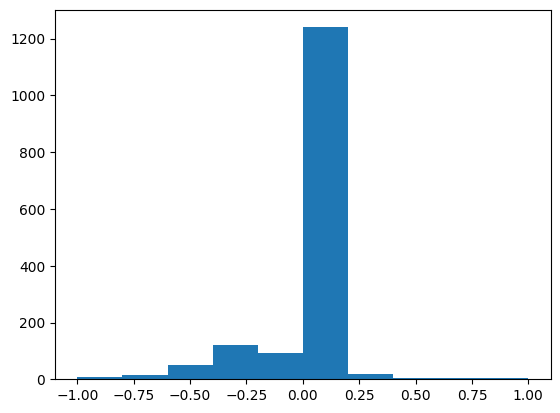

In [5]:
# Data dir
data_dir = 'dataset'
# Read file driving_log.csv with columns
data_df = pd.read_csv(os.path.join(os.getcwd(), data_dir, 'driving_log.csv'), names=['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed'])

# Get path for left, right, center camera
X = data_df[['center', 'left', 'right']].values
# Get steering angle
y = data_df['steering'].values

# Draw histogram
plt.hist(y)

(array([   7.,   15.,   50.,  121.,   94., 1025.,   19.,    6.,    4.,
           6.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <BarContainer object of 10 artists>)

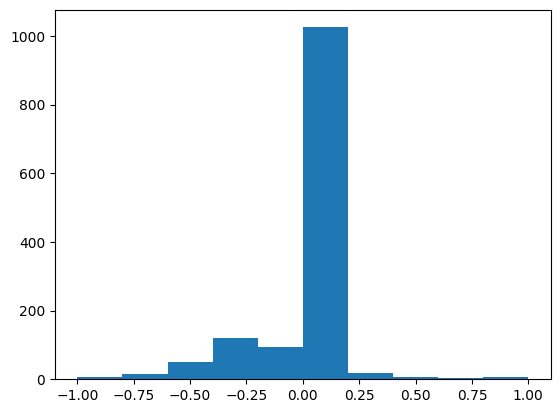

In [6]:
# Remove and get only 1000 data in left at 0
pos_zero = np.array(np.where(y==0)).reshape(-1, 1)
pos_none_zero = np.array(np.where(y!=0)).reshape(-1, 1)
np.random.shuffle(pos_zero)
pos_zero = pos_zero[:1000]

pos_combined = np.vstack((pos_zero, pos_none_zero))
pos_combined = list(pos_combined)

y = y[pos_combined].reshape(len(pos_combined))
X = X[pos_combined, :].reshape((len(pos_combined), 3))

# After process
plt.hist(y)

In [7]:
# Separate traing set and validation set
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=0)

In [16]:
# Build model
model = Sequential()
model.add(Lambda(lambda x: x/127.5-1.0, input_shape=INPUT_SHAPE))
model.add(Conv2D(24, (5, 5), activation='elu', strides=(2, 2)))
model.add(Conv2D(36, (5, 5), activation='elu', strides=(2, 2)))
model.add(Conv2D(48, (5, 5), activation='elu', strides=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='elu'))
model.add(Conv2D(64, (3, 3), activation='elu'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(100, activation='elu'))
model.add(Dropout(0.5))
model.add(Dense(50, activation='elu'))
model.add(Dense(10, activation='elu'))
model.add(Dense(1))
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_6 (Lambda)           (None, 66, 200, 3)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 31, 98, 24)        1824      
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 47, 36)        21636     
                                                                 
 conv2d_3 (Conv2D)           (None, 5, 22, 48)         43248     
                                                                 
 conv2d_4 (Conv2D)           (None, 3, 20, 64)         27712     
                                                                 
 conv2d_5 (Conv2D)           (None, 1, 18, 64)         36928     
                                                                 
 dropout (Dropout)           (None, 1, 18, 64)        

In [19]:
nb_epoch = 10
samples_per_epoch = 1000
batch_size = 32
save_best_only = True
learning_rate = 1e-4

# Checkpoint to save model when validation loss is minimize
checkpoint = ModelCheckpoint('models/model-{epoch:03d}.h5',
                                 monitor='val_loss',
                                 verbose=0,
                                 save_best_only=save_best_only,
                                 mode='auto')

# Use mean_squrared_error as loss function
model.compile(loss='mean_squared_error', optimizer=Adam(lr=learning_rate))

# Train model
H = model.fit_generator(batch_generator(data_dir, X_train, y_train, batch_size, True),
                    steps_per_epoch = samples_per_epoch,
                    epochs = nb_epoch,
                    max_queue_size=1,
                    validation_data=batch_generator(data_dir, X_valid, y_valid, batch_size, False),
                    validation_steps=len(X_valid),
                    callbacks=[checkpoint],
                    verbose=1)

Epoch 1/10


/home/namthai/miniconda3/envs/self-driving-car/lib/python3.11/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/tmp/ipykernel_14624/1326647012.py:18: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  H = model.fit_generator(batch_generator(data_dir, X_train, y_train, batch_size, True),
2023-05-22 01:19:29.025862: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1000/1000 [==============================] - ETA: 0s - loss: 0.0541

2023-05-22 01:21:03.589116: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1000/1000 [==============================] - 103s 103ms/step - loss: 0.0541 - val_loss: 0.0268
Epoch 2/10
1000/1000 [==============================] - 100s 100ms/step - loss: 0.0403 - val_loss: 0.0272
Epoch 3/10
1000/1000 [==============================] - 97s 97ms/step - loss: 0.0385 - val_loss: 0.0265
Epoch 4/10
1000/1000 [==============================] - 97s 97ms/step - loss: 0.0365 - val_loss: 0.0285
Epoch 5/10
1000/1000 [==============================] - 97s 97ms/step - loss: 0.0344 - val_loss: 0.0286
Epoch 6/10
1000/1000 [==============================] - 97s 97ms/step - loss: 0.0320 - val_loss: 0.0290
Epoch 7/10
1000/1000 [==============================] - 97s 97ms/step - loss: 0.0311 - val_loss: 0.0281
Epoch 8/10
1000/1000 [==============================] - 96s 96ms/step - loss: 0.0310 - val_loss: 0.0269
Epoch 9/10
1000/1000 [==============================] - 97s 97ms/step - loss: 0.0288 - val_loss: 0.0264
Epoch 10/10
1000/1000 [==============================] - 99s 99ms/step 